Question 05 - Foreground histogram equalization

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [2]:
input_image_path = Path("../data/a1images/jeniffer.jpg")
output_folder    = Path("../data/output_images")
os.makedirs(output_folder, exist_ok=True)

out_mask          = output_folder / "q5_mask.png"
out_result        = output_folder / "q5_equalized_foreground.png"
out_planes_figure = output_folder / "q5_planes_mask_original_result.png"
out_hist_cdf      = output_folder / "q5_foreground_hist_cdf.png"

In [3]:
# convert image to HSV, split into H,S,V and display as grayscale
img_bgr = cv.imread(str(input_image_path), cv.IMREAD_COLOR)
if img_bgr is None:
    raise FileNotFoundError(f"Could not find {input_image_path}")

img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
img_hsv = cv.cvtColor(img_bgr, cv.COLOR_BGR2HSV)     # keep HSV as uint8
H, S, V = cv.split(img_hsv)                          # each in [0,255]

In [4]:

# Build a foreground mask.
# Heuristic: background is usually low-saturation; threshold on S.

S_blur = cv.GaussianBlur(S, (5,5), 0)
# Otsu picks a robust threshold automatically; switch to fixed if needed.
_, mask_raw = cv.threshold(S_blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)


In [5]:
# Clean small specks / fill tiny gaps
kernel = np.ones((5,5), np.uint8)
mask = cv.morphologyEx(mask_raw, cv.MORPH_OPEN, kernel, iterations=1)
mask = cv.morphologyEx(mask,    cv.MORPH_CLOSE, kernel, iterations=1)
cv.imwrite(str(out_mask), mask)

True

In [6]:
# Obtain the foreground only using cv.bitwise_and and compute its histogram (on V)
V_fg = cv.bitwise_and(V, V, mask=mask)  # foreground values on V
# Histogram of foreground V using the mask (256 bins over [0,256))
hist = cv.calcHist([V], [0], mask, [256], [0,256]).ravel().astype(np.float64)


In [7]:
# (Cumulative sum (CDF) of the histogram using np.cumsum
cdf = np.cumsum(hist)
N   = cdf[-1] if cdf[-1] > 0 else 1.0                      # total foreground pixels
# cdf_min = first non-zero
nonzero = np.flatnonzero(hist)
cdf_min = cdf[nonzero[0]] if nonzero.size > 0 else 0.0

In [8]:
# Equalize ONLY the foreground using the slide formula
# T(i) = round( (CDF(i) - CDF_min) / (N - CDF_min) * 255 )
# Apply the mapping to V where mask>0; keep background unchanged.
lut = np.round((cdf - cdf_min) / max(N - cdf_min, 1.0) * 255.0)
lut = np.clip(lut, 0, 255).astype(np.uint8)                # 256-length LUT

V_eq = V.copy()
fg_idx = mask > 0
V_eq[fg_idx] = lut[V[fg_idx]]

In [9]:
# Recombine H,S, (equalized V for foreground only) and convert back to RGB
img_eq_bgr = cv.cvtColor(cv.merge([H, S, V_eq]), cv.COLOR_HSV2BGR)
img_eq_rgb = cv.cvtColor(img_eq_bgr, cv.COLOR_BGR2RGB)
cv.imwrite(str(out_result), img_eq_bgr)

True

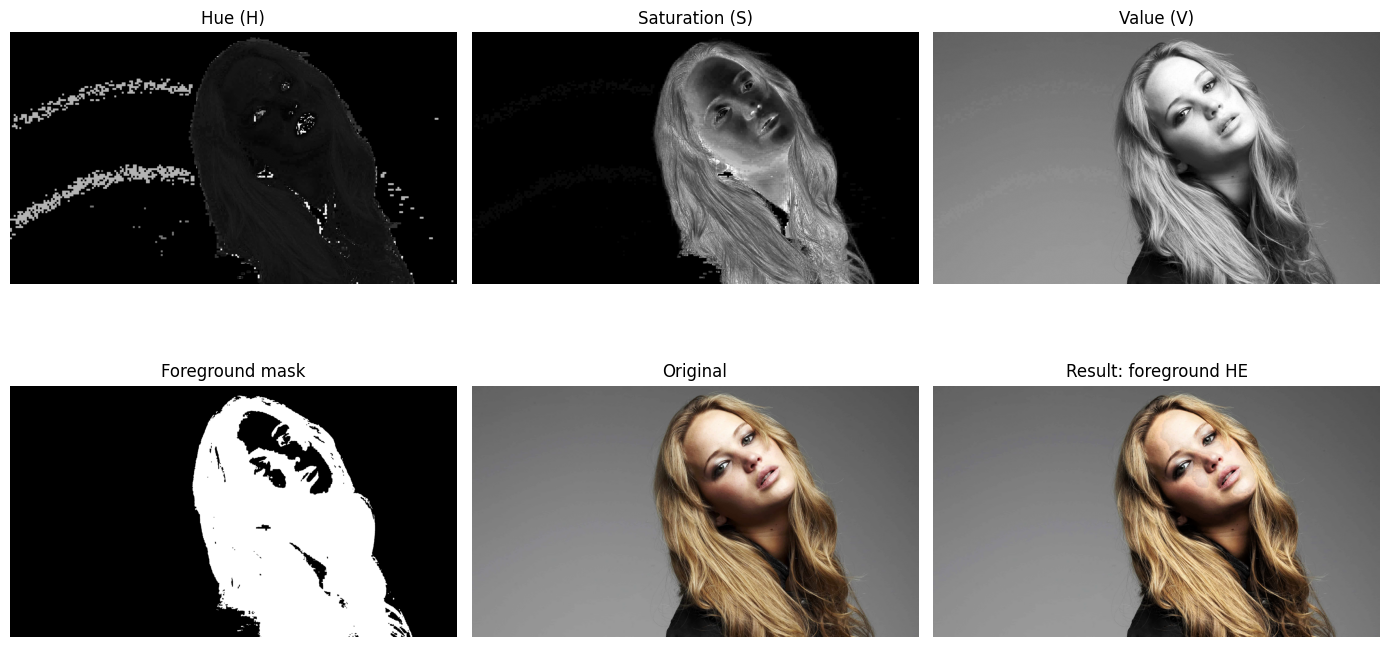

In [10]:
# Display: H, S, V planes (grayscale), the mask, the original image, and the final result
fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0,0]); ax1.imshow(H, cmap="gray"); ax1.set_title("Hue (H)"); ax1.axis("off")
ax2 = fig.add_subplot(gs[0,1]); ax2.imshow(S, cmap="gray"); ax2.set_title("Saturation (S)"); ax2.axis("off")
ax3 = fig.add_subplot(gs[0,2]); ax3.imshow(V, cmap="gray"); ax3.set_title("Value (V)"); ax3.axis("off")
ax4 = fig.add_subplot(gs[1,0]); ax4.imshow(mask, cmap="gray"); ax4.set_title("Foreground mask"); ax4.axis("off")
ax5 = fig.add_subplot(gs[1,1]); ax5.imshow(img_rgb); ax5.set_title("Original"); ax5.axis("off")
ax6 = fig.add_subplot(gs[1,2]); ax6.imshow(img_eq_rgb); ax6.set_title("Result: foreground HE"); ax6.axis("off")
plt.tight_layout()
plt.savefig(str(out_planes_figure), dpi=150)
plt.show()

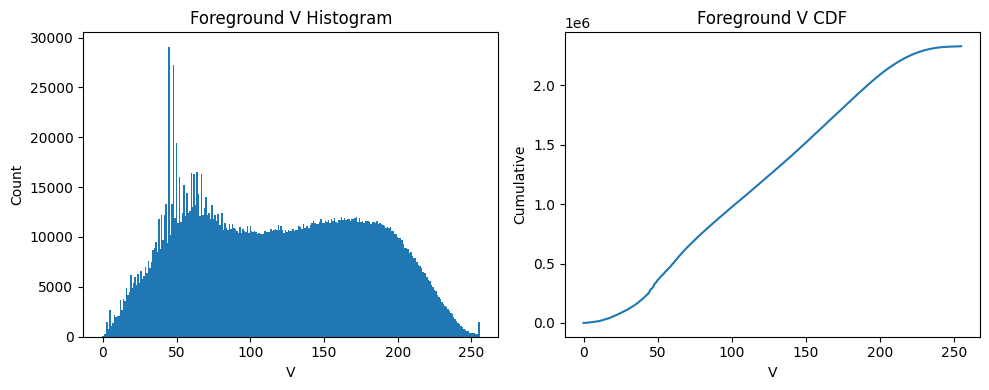

In [11]:
# Foreground histogram + CDF figure
x = np.arange(256)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Foreground V Histogram"); plt.bar(x, hist, width=1.0); plt.xlabel("V"); plt.ylabel("Count")
plt.subplot(1,2,2); plt.title("Foreground V CDF");       plt.plot(x, cdf);           plt.xlabel("V"); plt.ylabel("Cumulative")
plt.tight_layout(); plt.savefig(str(out_hist_cdf), dpi=150); plt.show()